In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import logging

base_dir = os.path.abspath("..")
sys.path.append(base_dir)

from utils.analyze_lensing import make_lensing_dataframe, \
    integrated_event_duration_posterior, t_of_tau, count_events_per_source, \
    count_filter_seq
from utils.mc_backgrounds import synthesize_background
from utils.plotting import plot_event
from utils.kde_label import cluster_label_dataframe
from dl import authClient as ac, queryClient as qc

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = os.path.join(base_dir, "plots/2sep2024_MC/")
results_dir = os.path.join(base_dir, "results/2sep2024_MC/")
log_dir = os.path.join(base_dir, "logs/2sep2024_MC/")

log_file = os.path.join(log_dir, "MC_results.log")
logging.basicConfig(filename=log_file, level=logging.ERROR)

In [2]:
lc_class_df = pd.read_parquet(f"{results_dir}lc_class.parquet")
aggregate_df = pd.read_parquet(f"{results_dir}aggregates.parquet")
lc_df = pd.read_parquet(f"{results_dir}mc_lightcurves.parquet")
results_df = pd.read_parquet(f"{results_dir}results.parquet")

results_df_irl = pd.read_parquet(f"{results_dir}irl_results.parquet")
lc_class_df_irl = pd.read_parquet(f"{os.path.join(base_dir, 'results/12aug2024/')}lc_class.parquet")
rng_state = pd.read_parquet(f"{log_dir}MC_rng_state.parquet")

In [3]:
filter_seq_hist = count_filter_seq(results_df)
filter_seq_hist_irl = count_filter_seq(results_df_irl)
filter_seq_hist.name = "Monte Carlo"
filter_seq_hist_irl.name = "Real Background"

filter_seq_hist_df = pd.concat([filter_seq_hist, filter_seq_hist_irl], axis=1)

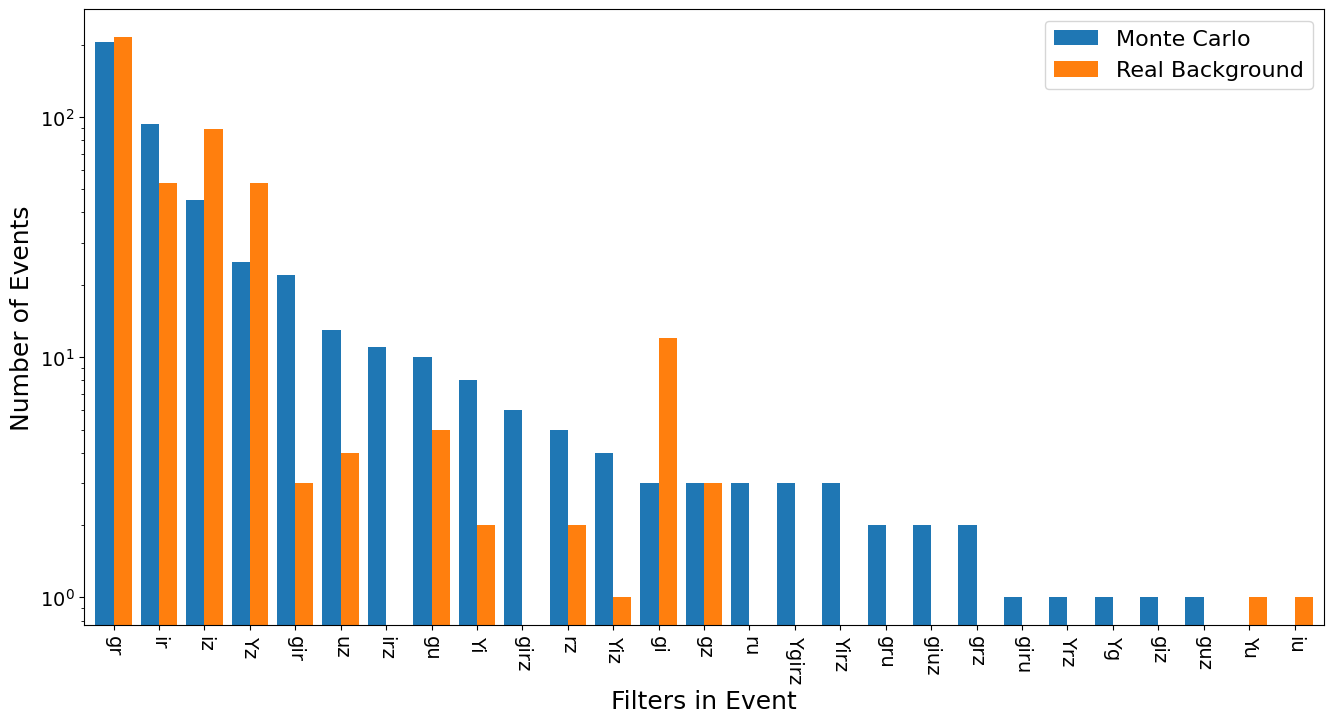

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))
filter_seq_hist_df.plot.bar(ax=ax, width=0.8)
ax.set_yscale("log")
ax.set_xlabel("Filters in Event", fontsize=18)
ax.set_ylabel("Number of Events", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
# fig.savefig(f"{fig_dir}filters_in_event_mc.png")
plt.show(fig)

In [5]:
ev_per_source = count_events_per_source(results_df)
n_per_source_hist = ev_per_source.value_counts()
n_per_source_hist.loc[0] = lc_class_df["lightcurve_class"].value_counts()["unimodal"]
n_per_source_hist.name = "Monte Carlo"

ev_per_source_irl = count_events_per_source(results_df_irl)
n_per_source_hist_irl = ev_per_source_irl.value_counts()
n_per_source_hist_irl.loc[0] = lc_class_df_irl["lightcurve_class"].value_counts()["unimodal"]
n_per_source_hist_irl.name = "Real Background"

ev_per_source_df = pd.concat([n_per_source_hist, n_per_source_hist_irl], axis=1)
ev_per_source_df.dropna(inplace=True)
ev_per_source_df.sort_index(inplace=True)

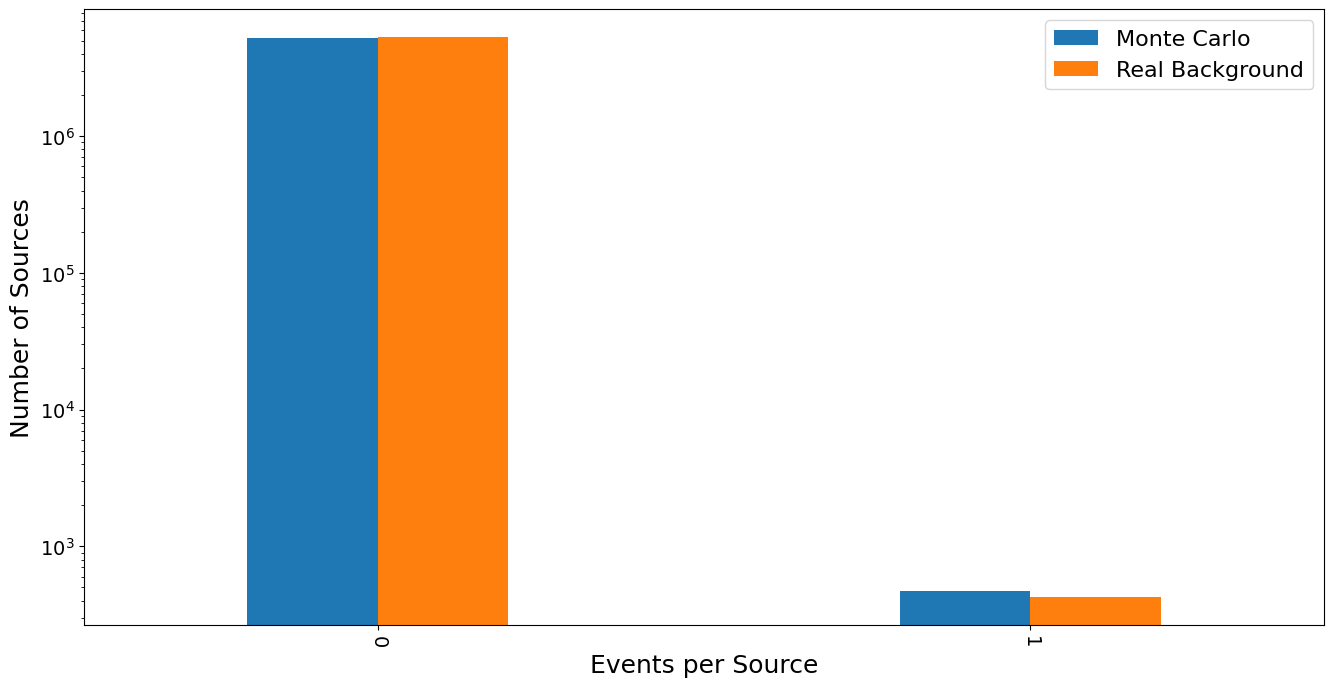

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
ev_per_source_df.plot.bar(ax=ax, width=0.4)
ax.set_yscale("log")
ax.set_xlabel("Events per Source", fontsize=18)
ax.set_ylabel("Number of Sources", fontsize=18)
ax.tick_params(labelsize=14)
ax.tick_params(axis='x', rotation=-90)
ax.legend(loc="upper right", fontsize=16)
# fig.savefig(f"{fig_dir}events_per_source_mc.png")
plt.show(fig)

In [7]:
taus = np.geomspace(1e-4, 1e4, num=50)
hist_counts = np.zeros((2, len(taus)))

dfs = [results_df, results_df_irl]

for j in range(len(dfs)):
    df = dfs[j]
    t_matrix = df[["t_start_max", "t_start_min", "t_end_min", "t_end_max"]].values

    for i in range(t_matrix.shape[0]):
        ts = t_matrix[i]
        post = integrated_event_duration_posterior(taus, ts)
        hist_counts[j] += post

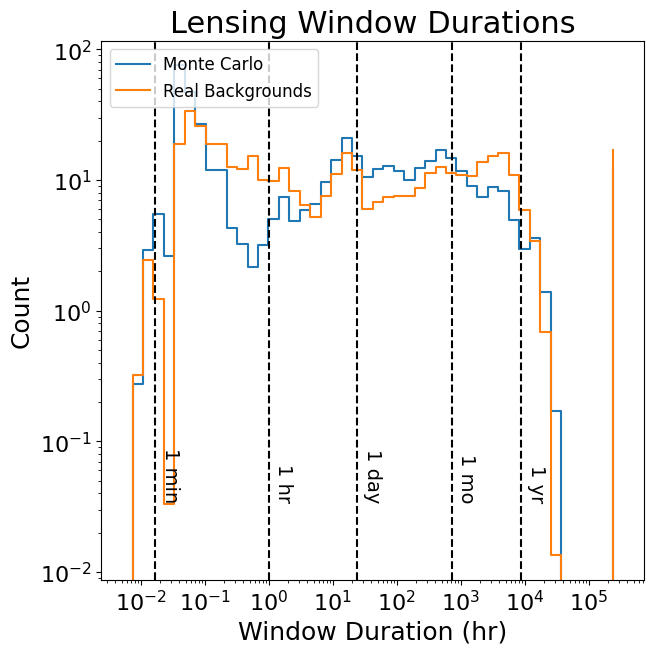

In [8]:
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 
                            60 * 60 * 24 * 30, 
                            60 * 60 * 24 * 365]) * (1 / 60**2))
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
x = taus * 24
labels = ["Monte Carlo", "Real Backgrounds"]

fig, ax = plt.subplots(figsize=(7, 7))

for i in range(len(labels)):
    h = hist_counts[i]
    label = labels[i]
    ax.plot(x, h, ds="steps-post", label=label)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.tick_params(labelsize=16)
ax.set_xlim((x[0], 3*x[-1]))
ax.legend(loc="upper left", fontsize=12)
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.15)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations_mc.png")
plt.close(fig)

In [9]:
temp = lc_class_df.copy()
temp.index = temp["objectid"]
temp.drop(columns="objectid", inplace=True)

temp2 = rng_state.copy()
temp2.index = temp2["objectid"]
temp2.drop(columns="objectid", inplace=True)

In [10]:
df = pd.concat([temp, temp2], axis=1, join="inner")

In [166]:
import utils.mc_backgrounds
from utils.plotting import plot_lightcurve

def get_lc(oid):
    q = f"""
    SELECT m.objectid, m.filter, m.mag_auto, m.magerr_auto, m.mjd, m.exposure, e.exptime
        FROM nsc_dr2.meas AS m
        INNER JOIN nsc_dr2.exposure AS e
        ON e.exposure = m.exposure
        WHERE m.objectid = '{oid}'
    """
    result = qc.query(sql=q, fmt="pandas")
    result.sort_values(by="mjd", inplace=True)
    return result

def set_rng_state(oid, rng_state_df, rng):
    rng_state = rng_state_df.loc[oid, "rng_state"]
    state_dict = rng.bit_generator.state
    state_dict.update({"state": {"state": int(rng_state), "inc": state_dict["state"]["inc"]}})
    rng.bit_generator.state = state_dict
    return rng

def lens_lc(oid, rates, taus, rng_state_df, rng):
    lc = get_lc(oid)
    rng = set_rng_state(oid, rng_state_df, rng)
    result = utils.mc_backgrounds.synthesize_background(lc, rates, taus, rng)
    return result

def plot_lensed_lc(lc, taus, rng_state_df, rng,
                   fig=None, **kwargs):
    oid = lc.iloc[0, 0]
    rng = set_rng_state(oid, rng_state_df, rng)

    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    else:
        ax = fig.get_axes()

    ax.cla()
    plot_lightcurve(lc, ax, **kwargs)
    t_last_sample = lc.iloc[-1, 4]
    t_first_sample = lc.iloc[0, 4]
    event_time = (t_last_sample - t_first_sample) + taus
    n_ev_exp = event_time * rates
    n_ev_drawn = rng.poisson(lam=n_ev_exp)
    result = lc.iloc[:, 2].copy()

    for i in range(len(taus)):
        n_ev = n_ev_drawn[i]
        tau = taus[i]
        start_times = rng.uniform(low=t_first_sample-tau, high=t_last_sample, size=n_ev)
    
        for st in start_times:
            lower_bound = st
            upper_bound = st + tau
            ax.axvspan(lower_bound, upper_bound, alpha=0.2, color="tab:gray")

    return fig

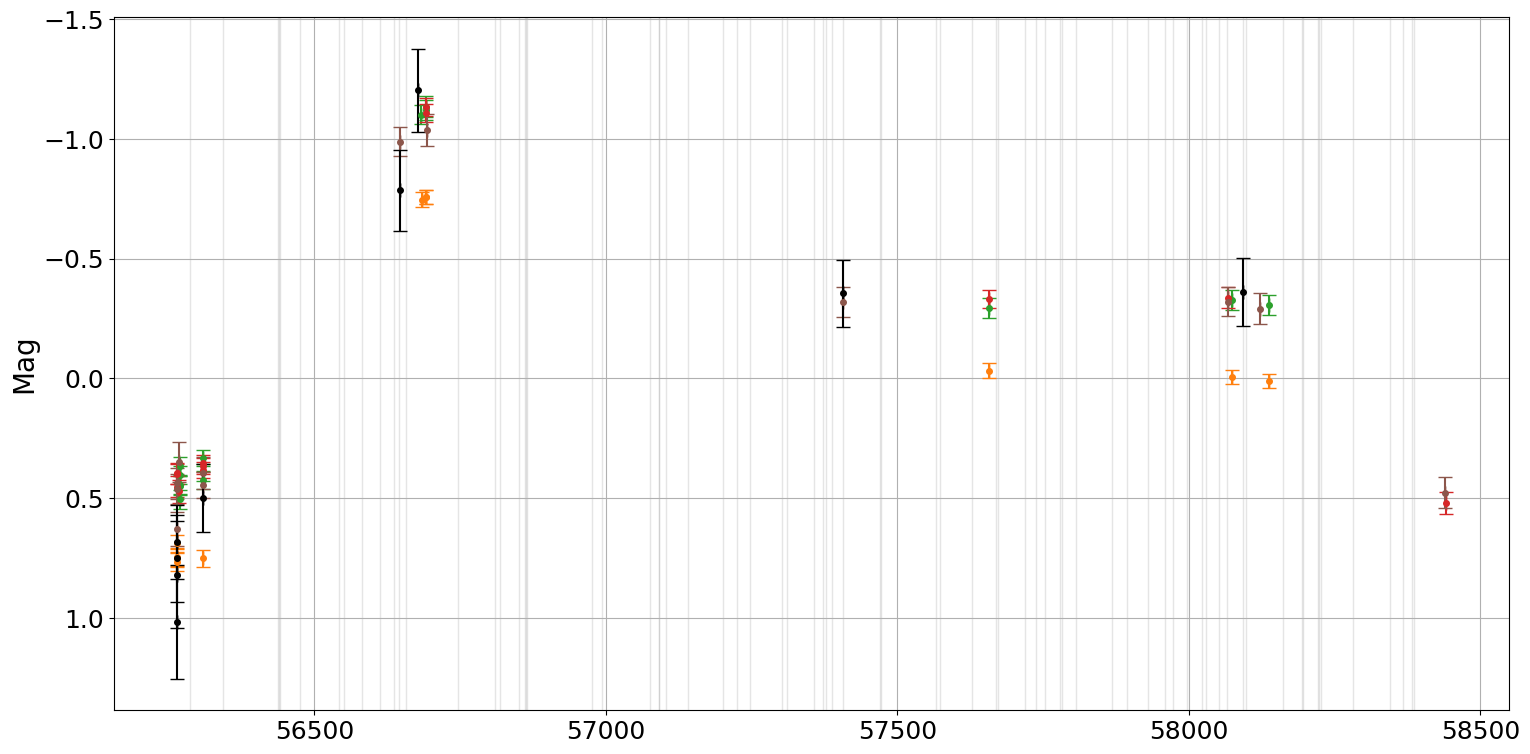

In [174]:
er_df = pd.read_parquet(f"{base_dir}/results/12aug2024/event_rates.parquet")
rates = er_df.loc["rate"]
taus = np.geomspace(1e-4, 1e4, num=50)
m = np.isfinite(rates)
rates = rates[m]
taus = taus[m]
rng = np.random.default_rng(seed=9047851)

oid = "182723_1654"
lc = lens_lc(oid, rates, taus, rng_state, rng)
lc = utils.kde_label.cluster_label_dataframe(lc)
g = lc.groupby(by=["objectid", "filter"], sort=False, group_keys=False)
temp = subtract_baseline(g)

fig = plot_lensed_lc(temp, taus, rng_state, rng,
                     mag_column="delta_mag",
                     magerr_column="delta_mag_err")
plt.show(fig)

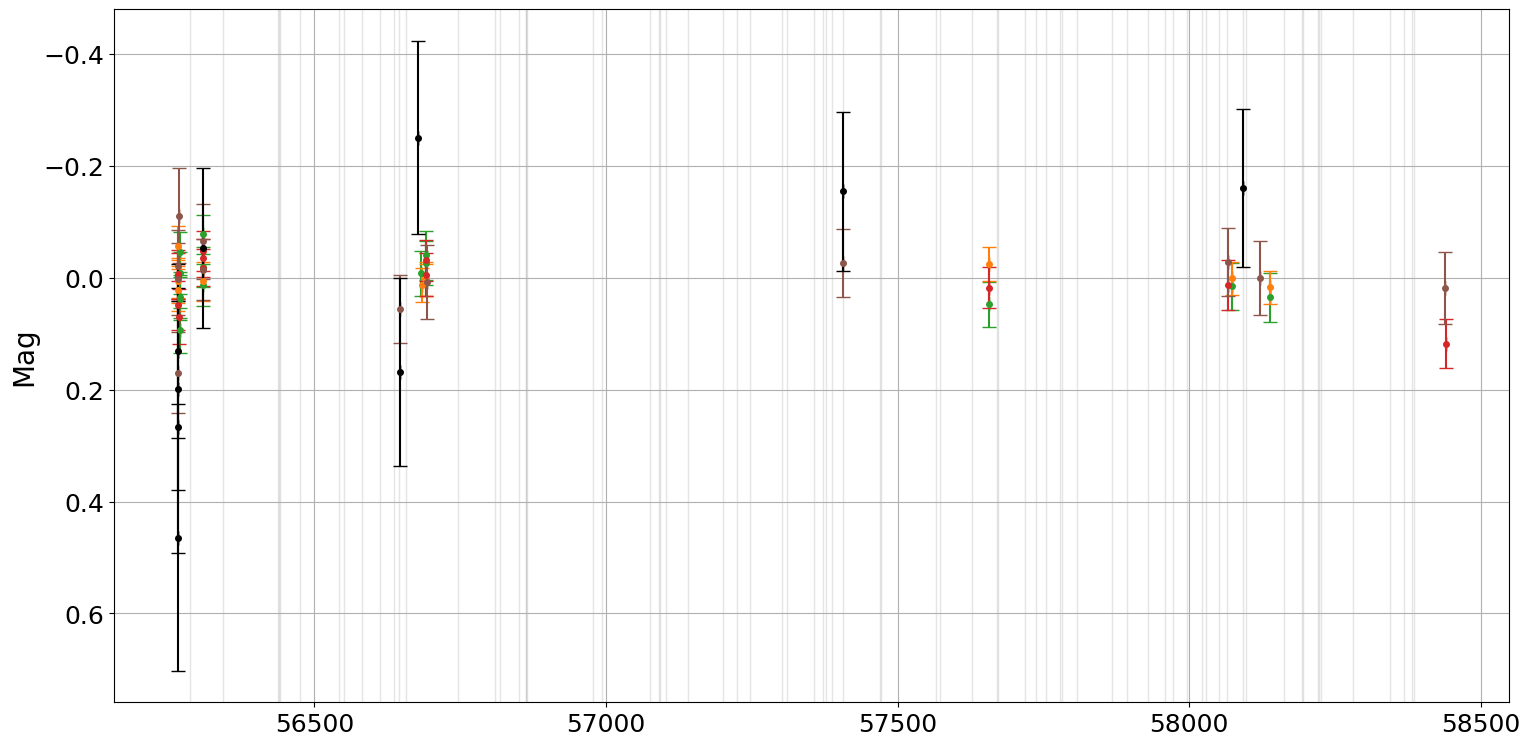

In [181]:
unlensed = get_lc(oid)
unlensed = cluster_label_dataframe(unlensed)
unlensed = subtract_baseline(unlensed.groupby(by=["objectid", "filter"], sort=False, group_keys=False))

fig = plot_lensed_lc(unlensed, taus, rng_state, rng,
                     mag_column="delta_mag",
                     magerr_column="delta_mag_err")
plt.show(fig)

In [182]:
unlensed["delta_mag"]

34    0.006565
15    0.022568
29   -0.056404
2     0.000840
37   -0.006140
7    -0.021699
28    0.131484
12    0.464312
14    0.049615
42    0.169717
19    0.267172
49   -0.002398
24    0.002305
46    0.199224
44    0.069662
39   -0.110841
1     0.034410
48   -0.008999
22    0.037201
32   -0.045710
33    0.093597
25   -0.047355
8    -0.065179
18   -0.053044
53   -0.018179
5    -0.035702
54   -0.014043
50   -0.018839
3     0.006710
6    -0.077750
16    0.013114
51    0.056605
45    0.168174
4    -0.250506
41   -0.007525
20    0.013323
43   -0.039687
47    0.002636
27   -0.005160
40   -0.026503
21    0.004267
36   -0.030978
13    0.008216
26   -0.026283
30   -0.154098
0     0.017686
56   -0.024292
11    0.047750
17    0.013168
57   -0.027823
31    0.001121
52    0.015489
38   -0.159724
10    0.000752
35    0.017050
55    0.035339
23    0.017959
9     0.117765
Name: delta_mag, dtype: float64

In [183]:
temp["delta_mag"] - unlensed["delta_mag"]

34    0.745260
15    0.745260
29    0.745260
2     0.745260
37    0.402747
7     0.460498
28    0.552434
12    0.552434
14    0.402747
42    0.460498
19    0.552434
49    0.402747
24    0.460498
46    0.552434
44    0.402747
39    0.460498
1     0.411353
48    0.411353
22    0.411353
32    0.411353
33    0.411353
25    0.402747
8     0.460498
18    0.552434
53    0.402747
5     0.402747
54    0.460498
50    0.411353
3     0.745260
6     0.411353
16    0.411353
51   -1.044652
45   -0.952716
4    -0.952716
41   -1.093797
20   -0.759890
43   -1.093797
47   -0.759890
27   -1.102403
40   -1.093797
21   -0.759890
36   -1.102403
13   -1.044652
26   -0.292077
30   -0.200141
0    -0.349828
56   -0.007315
11   -0.341222
17   -0.349828
57   -0.292077
31   -0.007315
52   -0.341222
38   -0.200141
10   -0.292077
35   -0.007315
55   -0.341222
23    0.460498
9     0.402747
Name: delta_mag, dtype: float64

In [130]:
event_df = results_df.loc[("180293_1972", slice(None))]

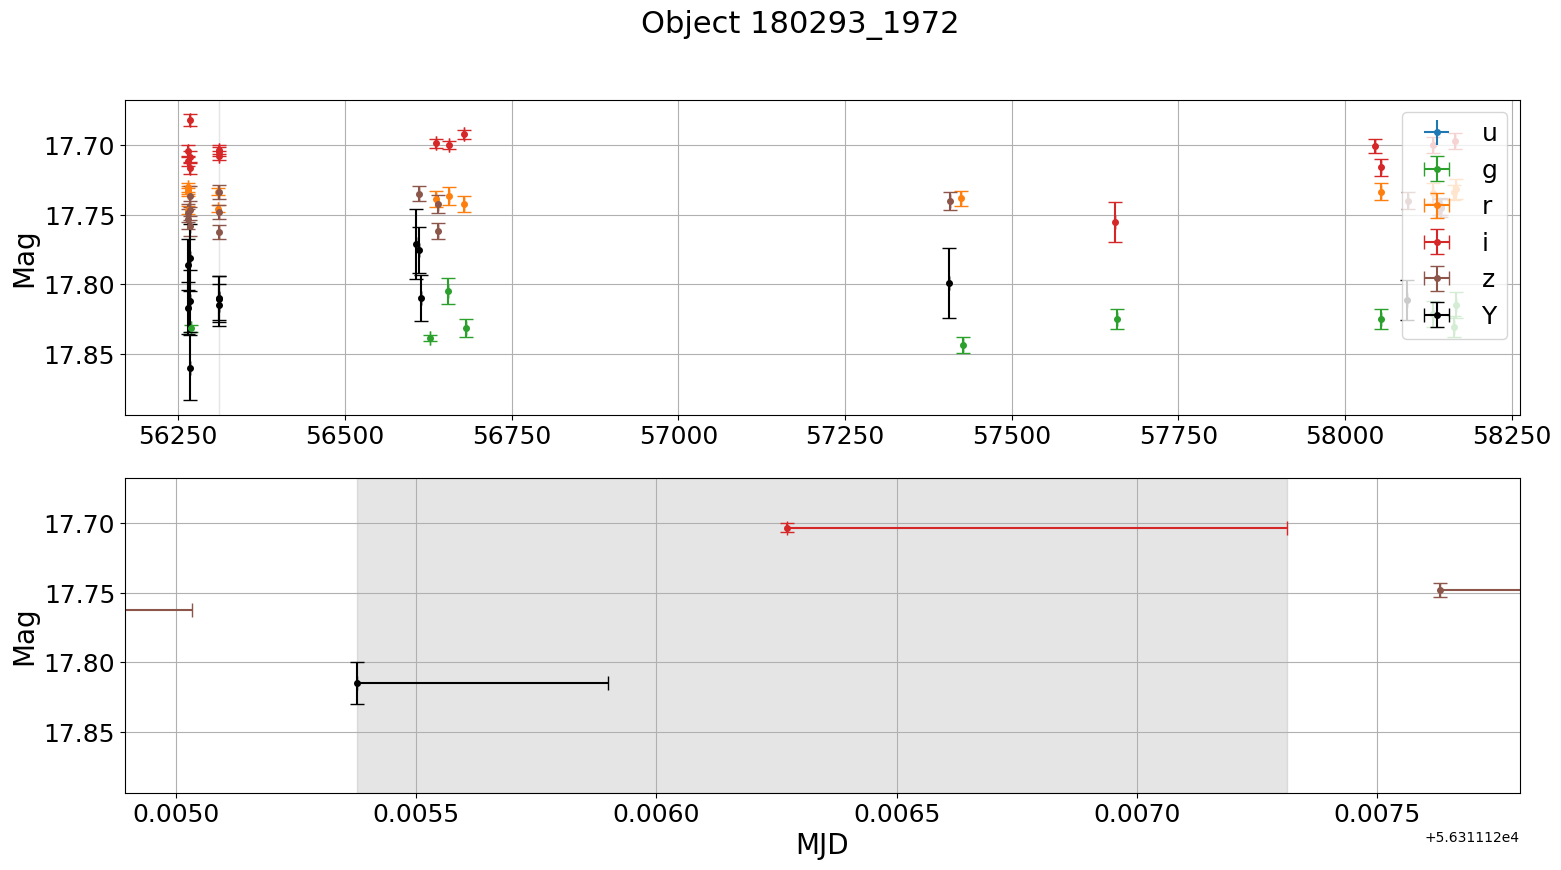

In [141]:
import importlib
importlib.reload(utils.plotting)
import utils.plotting

fig = utils.plotting.plot_event(event_df, lc)
plt.show(fig)

In [127]:
event_df = results_df.loc[(lc.iloc[0, 0], slice(None))]
fig = plot_lensed_lc(lc, taus, rng_state, results_df, rng)

KeyError: '185282_8544'